Initial bed configuration: {'A': 48, 'B': 33, 'C': 23, 'D': 14, 'E': 13, 'F': 34}
Total beds: 165

Starting optimization process...
Stopping early at iteration 597 due to no improvement.


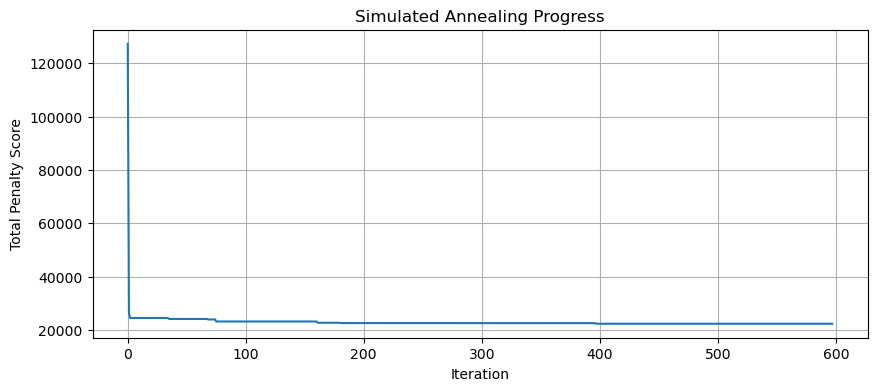


--- Best Bed Allocation Found by Optimizer ---
  Ward A: 48 beds
  Ward B: 34 beds
  Ward C: 18 beds
  Ward D: 15 beds
  Ward E: 14 beds
  Ward F: 36 beds

Minimum Total Penalty Found: 22374.00
Time Taken for optimization: 42.16 seconds

--- Verifying performance of best configuration ---
  Verification Run - Final Penalty Score: 58072.00
  Verification Run - Ward F Admission Rate: 97.09%


In [1]:
import numpy as np
import random
import heapq
import matplotlib.pyplot as plt
import time

# ==============================================================================
# PART 1: The Core Simulation Model
# ==============================================================================
# This class represents the hospital and contains all the rules for patient flow.
# It is the "engine" that the optimizer will use to test different scenarios.

class HospitalModel:
    """Represents the hospital's rules, state, and statistics for a single simulation run."""
    def __init__(self, bed_config):
        # --- Static Parameters (The "Rules") ---
        self.wards = list(bed_config.keys())
        self.capacities = bed_config.copy()
        self.arrival_rates = {'A': 14.5, 'B': 11.0, 'C': 8.0, 'D': 6.5, 'E': 5.0, 'F': 13.0}
        self.mean_stays = {'A': 2.9, 'B': 4.0, 'C': 4.5, 'D': 1.4, 'E': 3.9, 'F': 2.2}
        self.urgency_points = {'A': 7, 'B': 5, 'C': 2, 'D': 10, 'E': 5, 'F': 0}
        self.reloc_probs = {
            'A': {'B': 0.05, 'C': 0.10, 'D': 0.05, 'E': 0.80},
            'B': {'A': 0.20, 'C': 0.50, 'D': 0.15, 'E': 0.15},
            'C': {'A': 0.30, 'B': 0.20, 'D': 0.20, 'E': 0.30},
            'D': {'A': 0.35, 'B': 0.30, 'C': 0.05, 'E': 0.30},
            'E': {'A': 0.20, 'B': 0.10, 'C': 0.60, 'D': 0.10},
            'F': {'A': 0.20, 'B': 0.20, 'C': 0.20, 'D': 0.20, 'E': 0.20}
        }
        
        # --- Dynamic State Variables (What changes during simulation) ---
        self.occupied_beds = {w: 0 for w in self.wards}
        self.stats = {
            'total_arrivals': {w: 0 for w in self.wards},
            'primary_admissions': {w: 0 for w in self.wards},
            'relocated_from': {w: 0 for w in self.wards},
            'lost_patients': {w: 0 for w in self.wards}
        }

    def handle_arrival(self, patient_type):
        """Handles a patient arrival and returns the ward they were admitted to (or None)."""
        self.stats['total_arrivals'][patient_type] += 1
        
        # --- Primary Admission Attempt ---
        if self.occupied_beds[patient_type] < self.capacities[patient_type]:
            self.occupied_beds[patient_type] += 1
            self.stats['primary_admissions'][patient_type] += 1
            return patient_type
        
        # --- Relocation Attempt ---
        else:
            self.stats['relocated_from'][patient_type] += 1
            
            # Choose an alternative ward based on probabilities
            reloc_options = self.reloc_probs.get(patient_type, {})
            if not reloc_options: # Handle case where a type has no relocation options
                self.stats['lost_patients'][patient_type] += 1
                return None
                
            wards = list(reloc_options.keys())
            probs = list(reloc_options.values())
            alt_ward = np.random.choice(wards, p=probs)
            
            if self.occupied_beds[alt_ward] < self.capacities[alt_ward]:
                self.occupied_beds[alt_ward] += 1
                return alt_ward
            else:
                self.stats['lost_patients'][patient_type] += 1
                return None

    def handle_departure(self, ward_of_admission):
        """Frees up a bed in the specified ward."""
        if self.occupied_beds[ward_of_admission] > 0:
            self.occupied_beds[ward_of_admission] -= 1

def simulate_hospital_flow(bed_config, duration=365, burn_in=50):
    """
    This is the main simulation function. It takes a bed layout and returns
    the key performance metrics needed by the optimizer.
    """
    model = HospitalModel(bed_config)
    event_list = []
    current_time = 0.0

    def schedule_event(delay, event_type, details):
        heapq.heappush(event_list, (current_time + delay, event_type, details))

    # Kickstart by scheduling the first arrival for each patient type
    for p_type in model.wards:
        if p_type in model.arrival_rates:
            delay = np.random.exponential(1.0 / model.arrival_rates[p_type])
            schedule_event(delay, 'ARRIVAL', {'patient_type': p_type})

    # Main simulation loop
    while event_list and current_time < duration:
        time, event_type, details = heapq.heappop(event_list)
        current_time = time

        if event_type == 'ARRIVAL':
            p_type = details['patient_type']
            # Always schedule the next arrival for this type
            delay = np.random.exponential(1.0 / model.arrival_rates[p_type])
            schedule_event(delay, 'ARRIVAL', {'patient_type': p_type})
            
            # Only process/collect stats after the burn-in period
            if current_time > burn_in:
                ward_admitted = model.handle_arrival(p_type)
                if ward_admitted:
                    stay = np.random.exponential(model.mean_stays[p_type])
                    schedule_event(stay, 'DEPARTURE', {'ward': ward_admitted})
        
        elif event_type == 'DEPARTURE':
            if current_time > burn_in:
                model.handle_departure(details['ward'])

    # --- Calculate final metrics at the end of the simulation ---
    # 1. Total penalty score from relocated patients
    total_penalty = sum(model.urgency_points[w] * model.stats['relocated_from'][w] for w in model.wards if w != 'F')
    
    # 2. Admission rate for Ward F
    f_arrivals = model.stats['total_arrivals']['F']
    f_admissions = model.stats['primary_admissions']['F']
    f_admission_rate = (f_admissions / f_arrivals) if f_arrivals > 0 else 1.0

    return f_admission_rate, total_penalty


# ==============================================================================
# PART 2: The Simulated Annealing Optimizer
# ==============================================================================
# This section uses the simulation model to find the best bed layout.

def objective_function(bed_config):
    """
    This is the function the optimizer tries to minimize.
    It returns a single "cost" value for a given bed layout.
    """
    f_admission_rate, penalty_score = simulate_hospital_flow(bed_config=bed_config)
    
    # Add a massive penalty if the Ward F admission constraint is violated.
    # This forces the optimizer to find solutions that are valid.
    if f_admission_rate < 0.95:
        penalty_score += 100000 

    return penalty_score

def generate_neighbor(config, src_weights):
    """
    Creates a new "neighbor" configuration by intelligently moving one bed.
    """
    config = config.copy()
    
    # Choose a source ward to take a bed FROM.
    # It must have beds to give and we prefer to take from low-urgency wards.
    valid_sources = {w: weight for w, weight in src_weights.items() if config[w] > 0}
    if not valid_sources: return config
    
    items = list(valid_sources.items())
    wards, weights = zip(*items)
    total_weight = sum(weights)
    probs = [w / total_weight for w in weights]
    src = np.random.choice(wards, p=probs)

    # Choose a destination ward to give the bed TO.
    dst_candidates = [w for w in config.keys() if w != src]
    dst = random.choice(dst_candidates)

    config[src] -= 1
    config[dst] += 1
    return config

def simulated_annealing_optimizer(initial_config, src_weights, max_iter=2000):
    """
    The main simulated annealing algorithm.
    """
    current_config = initial_config.copy()
    current_cost = objective_function(current_config)
    
    best_config = current_config.copy()
    best_cost = current_cost
    
    cost_history = [current_cost]
    patience = 200
    stall_counter = 0

    T0 = 20.0  # Initial temperature
    T_end = 0.1 # Final temperature

    for k in range(1, max_iter + 1):
        T = T0 * (T_end / T0) ** (k / max_iter)
        
        neighbor_config = generate_neighbor(current_config, src_weights)
        cost = objective_function(neighbor_config)
        
        delta = cost - current_cost
        
        # Metropolis acceptance criterion
        if delta < 0 or random.random() < np.exp(-delta / T):
            current_config = neighbor_config
            current_cost = cost
        
        # Track the best valid solution found so far
        if current_cost < best_cost:
            best_config = current_config.copy()
            best_cost = current_cost
            stall_counter = 0
        else:
            stall_counter += 1
        
        cost_history.append(current_cost)
        
        if stall_counter >= patience:
            print(f"Stopping early at iteration {k} due to no improvement.")
            break
            
    # Plot the optimization progress
    plt.figure(figsize=(10,4))
    plt.plot(cost_history)
    plt.title("Simulated Annealing Progress")
    plt.xlabel("Iteration")
    plt.ylabel("Total Penalty Score")
    plt.grid(True)
    plt.show()

    return best_config, best_cost

# ==============================================================================
# PART 3: Main Execution Block
# ==============================================================================

# --- Define Global Parameters for the run ---
WARDS = ['A', 'B', 'C', 'D', 'E', 'F']
urgency_points = {'A': 7, 'B': 5, 'C': 2, 'D': 10, 'E': 5, 'F': 0}
src_weights = {w: 1 / urgency_points[w] if urgency_points.get(w, 0) > 0 else 0 for w in WARDS if w != 'F'}

# --- Set Initial Configuration ---
# Start with a simple, balanced configuration.
initial_beds = {'A': 48, 'B': 33, 'C': 23, 'D': 14, 'E': 13, 'F': 34} 
print(f"Initial bed configuration: {initial_beds}")
print(f"Total beds: {sum(initial_beds.values())}")

# --- Run the Optimizer ---
print("\nStarting optimization process...")
start_time = time.time()
best_config, best_cost = simulated_annealing_optimizer(initial_beds, src_weights)
end_time = time.time()

# --- Report Final Results ---
print("\n--- Best Bed Allocation Found by Optimizer ---")
for ward in WARDS:
    print(f"  Ward {ward}: {best_config[ward]} beds")

print(f"\nMinimum Total Penalty Found: {best_cost:.2f}")
print(f"Time Taken for optimization: {end_time - start_time:.2f} seconds")

# --- Final verification run with the best configuration ---
print("\n--- Verifying performance of best configuration ---")
final_f_rate, final_penalty = simulate_hospital_flow(best_config, duration=365*2, burn_in=50)
print(f"  Verification Run - Final Penalty Score: {final_penalty:.2f}")
print(f"  Verification Run - Ward F Admission Rate: {final_f_rate:.2%}")



Initial bed configuration: {'A': 48, 'B': 33, 'C': 23, 'D': 13, 'E': 13, 'F': 35}
Total beds: 165

Starting optimization process...
Stopping early at iteration 684 after 400 iterations.


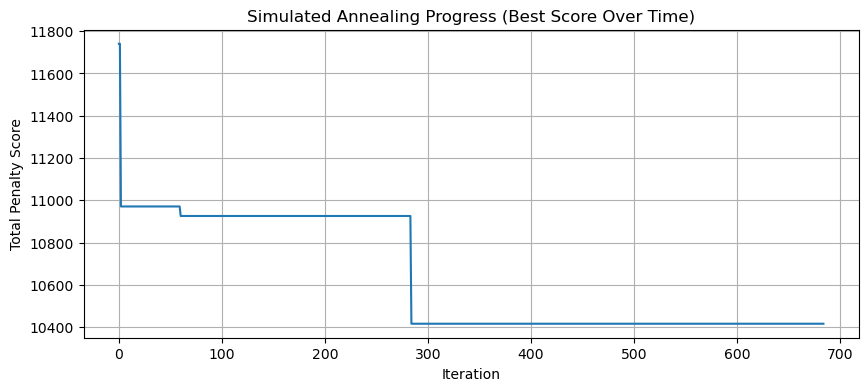


--- Best Bed Allocation Found by Optimizer ---
  Ward A: 49 beds
  Ward B: 32 beds
  Ward C: 21 beds
  Ward D: 14 beds
  Ward E: 14 beds
  Ward F: 35 beds

Minimum Average Penalty Found during optimization: 10416.67
Time Taken for optimization: 68.63 seconds

--- Verifying performance of best configuration with long, stable runs ---
  Verification Run - Final Average Penalty Score: 24613.40


In [1]:
import numpy as np
import random
import heapq
import matplotlib.pyplot as plt
import time

# ==============================================================================
# PART 1: The Core Simulation Model
# ==============================================================================
# This class represents the hospital and contains all the rules for patient flow.

class HospitalModel:
    """Represents the hospital's rules, state, and statistics for a single simulation run."""
    def __init__(self, bed_config):
        self.wards = list(bed_config.keys())
        self.capacities = bed_config.copy()
        self.arrival_rates = {'A': 14.5, 'B': 11.0, 'C': 8.0, 'D': 6.5, 'E': 5.0, 'F': 13.0}
        self.mean_stays = {'A': 2.9, 'B': 4.0, 'C': 4.5, 'D': 1.4, 'E': 3.9, 'F': 2.2}
        self.urgency_points = {'A': 7, 'B': 5, 'C': 2, 'D': 10, 'E': 5, 'F': 0}
        self.reloc_probs = {
            'A': {'B': 0.05, 'C': 0.10, 'D': 0.05, 'E': 0.80},
            'B': {'A': 0.20, 'C': 0.50, 'D': 0.15, 'E': 0.15},
            'C': {'A': 0.30, 'B': 0.20, 'D': 0.20, 'E': 0.30},
            'D': {'A': 0.35, 'B': 0.30, 'C': 0.05, 'E': 0.30},
            'E': {'A': 0.20, 'B': 0.10, 'C': 0.60, 'D': 0.10},
            'F': {'A': 0.20, 'B': 0.20, 'C': 0.20, 'D': 0.20, 'E': 0.20}
        }
        
        self.occupied_beds = {w: 0 for w in self.wards}
        self.stats = {
            'total_arrivals': {w: 0 for w in self.wards},
            'primary_admissions': {w: 0 for w in self.wards},
            'relocated_from': {w: 0 for w in self.wards},
            'lost_patients': {w: 0 for w in self.wards}
        }

    def handle_arrival(self, patient_type):
        """Handles a patient arrival and returns the ward they were admitted to (or None)."""
        self.stats['total_arrivals'][patient_type] += 1
        
        if self.occupied_beds[patient_type] < self.capacities[patient_type]:
            self.occupied_beds[patient_type] += 1
            self.stats['primary_admissions'][patient_type] += 1
            return patient_type
        else:
            self.stats['relocated_from'][patient_type] += 1
            reloc_options = self.reloc_probs.get(patient_type, {})
            if not reloc_options:
                self.stats['lost_patients'][patient_type] += 1
                return None
            wards, probs = zip(*reloc_options.items())
            alt_ward = np.random.choice(wards, p=probs)
            
            if self.occupied_beds[alt_ward] < self.capacities[alt_ward]:
                self.occupied_beds[alt_ward] += 1
                return alt_ward
            else:
                self.stats['lost_patients'][patient_type] += 1
                return None

    def handle_departure(self, ward_of_admission):
        if self.occupied_beds[ward_of_admission] > 0:
            self.occupied_beds[ward_of_admission] -= 1

def simulate_hospital_flow(bed_config, duration=365, burn_in=60):
    """The main simulation function used to evaluate a bed configuration."""
    model = HospitalModel(bed_config)
    event_list = []
    current_time = 0.0

    def schedule_event(delay, event_type, details):
        heapq.heappush(event_list, (current_time + delay, event_type, details))

    for p_type in model.wards:
        if p_type in model.arrival_rates:
            delay = np.random.exponential(1.0 / model.arrival_rates[p_type])
            schedule_event(delay, 'ARRIVAL', {'patient_type': p_type})

    while event_list and current_time < duration:
        time, event_type, details = heapq.heappop(event_list)
        current_time = time

        if event_type == 'ARRIVAL':
            p_type = details['patient_type']
            delay = np.random.exponential(1.0 / model.arrival_rates[p_type])
            schedule_event(delay, 'ARRIVAL', {'patient_type': p_type})
            
            if current_time > burn_in:
                ward_admitted = model.handle_arrival(p_type)
                if ward_admitted:
                    stay = np.random.exponential(model.mean_stays[p_type])
                    schedule_event(stay, 'DEPARTURE', {'ward': ward_admitted})
        
        elif event_type == 'DEPARTURE':
            if current_time > burn_in:
                model.handle_departure(details['ward'])

    total_penalty = sum(model.urgency_points[w] * model.stats['relocated_from'][w] for w in model.wards if w != 'F')
    f_arrivals = model.stats['total_arrivals'].get('F', 0)
    f_admissions = model.stats['primary_admissions'].get('F', 0)
    f_admission_rate = (f_admissions / f_arrivals) if f_arrivals > 0 else 1.0

    return f_admission_rate, total_penalty

# ==============================================================================
# PART 2: The Simulated Annealing Optimizer
# ==============================================================================

def objective_function(bed_config, n_runs=3):
    """
    IMPROVEMENT 1: The objective function is now more robust. It runs the 
    simulation multiple times and averages the results to get a more stable, 
    less noisy cost estimate for the optimizer to use.
    """
    penalties, f_rates = [], []
    for _ in range(n_runs):
        f_rate, penalty = simulate_hospital_flow(bed_config, duration=180, burn_in=30)
        penalties.append(penalty)
        f_rates.append(f_rate)

    avg_penalty = np.mean(penalties)
    avg_f_rate = np.mean(f_rates)

    if avg_f_rate < 0.95:
        avg_penalty += 100000 
    return avg_penalty

def generate_neighbor(config, src_weights):
    """
    IMPROVEMENT 2: The logic for generating a new solution to test is balanced.
    It intelligently chooses a source ward to take a bed FROM (preferring low
    urgency), but chooses the destination ward randomly. This provides a good
    mix of guided search and random exploration to avoid getting stuck.
    """
    config = config.copy()
    
    valid_sources = {w: weight for w, weight in src_weights.items() if config[w] > 0}
    if not valid_sources: return config
    
    wards, weights = zip(*valid_sources.items())
    src = np.random.choice(wards, p=[w/sum(weights) for w in weights])

    dst_candidates = [w for w in config.keys() if w != src]
    dst = random.choice(dst_candidates)

    config[src] -= 1
    config[dst] += 1
    return config

def simulated_annealing_optimizer(initial_config, src_weights, max_iter=2500):
    """
    The main simulated annealing algorithm with parameters tuned for better results.
    """
    current_config = initial_config.copy()
    current_cost = objective_function(current_config, n_runs=5) 
    
    best_config = current_config.copy()
    best_cost = current_cost
    cost_history = [current_cost]
    
    # IMPROVEMENT 3: Annealing parameters are tuned for a more thorough search.
    patience = 400
    stall_counter = 0
    T0 = 100.0  # Start hotter to explore more widely at the beginning.
    T_end = 0.1   # Cool down further to fine-tune the solution at the end.

    for k in range(1, max_iter + 1):
        T = T0 * (T_end / T0) ** (k / max_iter)
        
        neighbor = generate_neighbor(current_config, src_weights)
        cost = objective_function(neighbor, n_runs=3) 
        
        delta = cost - current_cost
        
        if delta < 0 or (T > 0 and random.random() < np.exp(-delta / T)):
            current_config = neighbor
            current_cost = cost
        
        if current_cost < best_cost:
            best_config = current_config.copy()
            best_cost = current_cost
            stall_counter = 0
        else:
            stall_counter += 1
        
        cost_history.append(best_cost)
        
        if stall_counter >= patience:
            print(f"Stopping early at iteration {k} after {patience} iterations.")
            break
            
    plt.figure(figsize=(10,4))
    plt.plot(cost_history)
    plt.title("Simulated Annealing Progress (Best Score Over Time)")
    plt.xlabel("Iteration")
    plt.ylabel("Total Penalty Score")
    plt.grid(True)
    plt.show()

    return best_config, best_cost

# ==============================================================================
# PART 3: Main Execution Block
# ==============================================================================

random.seed(42)
np.random.seed(42)

WARDS = ['A', 'B', 'C', 'D', 'E', 'F']
urgency_points = {'A': 7, 'B': 5, 'C': 2, 'D': 10, 'E': 5, 'F': 0}
src_weights = {w: 1 / urgency_points[w] for w in WARDS if w != 'F'}

initial_beds = {'A': 48, 'B': 33, 'C': 23, 'D': 13, 'E': 13, 'F': 34}
print(f"Initial bed configuration: {initial_beds}")
print(f"Total beds: {sum(initial_beds.values())}")

print("\nStarting optimization process...")
start_time = time.time()
best_config, best_cost = simulated_annealing_optimizer(initial_beds, src_weights)
end_time = time.time()

print("\n--- Best Bed Allocation Found by Optimizer ---")
for ward in WARDS:
    print(f"  Ward {ward}: {best_config[ward]} beds")

print(f"\nMinimum Average Penalty Found during optimization: {best_cost:.2f}")
print(f"Time Taken for optimization: {end_time - start_time:.2f} seconds")

print("\n--- Verifying performance of best configuration with long, stable runs ---")
final_penalties = []
for _ in range(10): 
    _, penalty = simulate_hospital_flow(best_config, duration=365, burn_in=60)
    final_penalties.append(penalty)

print(f"  Verification Run - Final Average Penalty Score: {np.mean(final_penalties):.2f}")


Initial bed configuration: {'A': 48, 'B': 33, 'C': 23, 'D': 13, 'E': 13, 'F': 35}
Total beds: 165

Starting optimization process...
Stopping early at iteration 684 after 400 iterations.


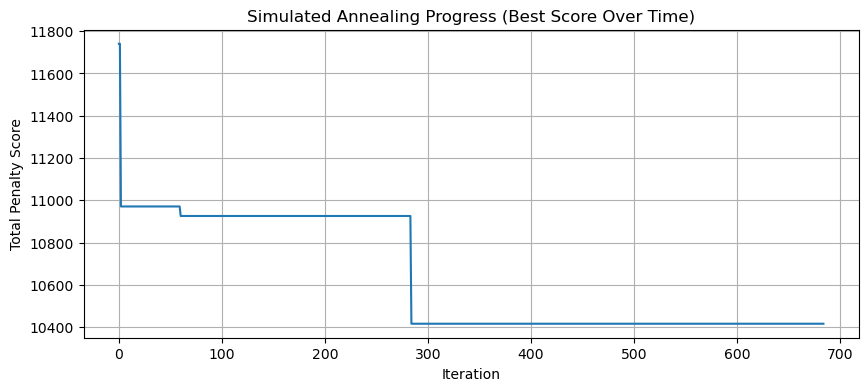


--- Best Bed Allocation Found by Optimizer ---
  Ward A: 49 beds
  Ward B: 32 beds
  Ward C: 21 beds
  Ward D: 14 beds
  Ward E: 14 beds
  Ward F: 35 beds

Minimum Average Penalty Found during optimization: 10416.67
Time Taken for optimization: 70.43 seconds

--- Verifying performance of best configuration with long, stable runs ---
  Verification Run - Final Average Penalty Score: 24613.40


In [2]:
import numpy as np
import random
import heapq
import matplotlib.pyplot as plt
import time

# ==============================================================================
# PART 1: The Core Simulation Model
# ==============================================================================
# This class represents the hospital and contains all the rules for patient flow.

class HospitalModel:
    """Represents the hospital's rules, state, and statistics for a single simulation run."""
    def __init__(self, bed_config):
        # --- Static Parameters (The "Rules") ---
        self.wards = list(bed_config.keys())
        self.capacities = bed_config.copy()
        self.arrival_rates = {'A': 14.5, 'B': 11.0, 'C': 8.0, 'D': 6.5, 'E': 5.0, 'F': 13.0}
        self.mean_stays = {'A': 2.9, 'B': 4.0, 'C': 4.5, 'D': 1.4, 'E': 3.9, 'F': 2.2}
        self.urgency_points = {'A': 7, 'B': 5, 'C': 2, 'D': 10, 'E': 5, 'F': 0}
        self.reloc_probs = {
            'A': {'B': 0.05, 'C': 0.10, 'D': 0.05, 'E': 0.80},
            'B': {'A': 0.20, 'C': 0.50, 'D': 0.15, 'E': 0.15},
            'C': {'A': 0.30, 'B': 0.20, 'D': 0.20, 'E': 0.30},
            'D': {'A': 0.35, 'B': 0.30, 'C': 0.05, 'E': 0.30},
            'E': {'A': 0.20, 'B': 0.10, 'C': 0.60, 'D': 0.10},
            'F': {'A': 0.20, 'B': 0.20, 'C': 0.20, 'D': 0.20, 'E': 0.20}
        }
        
        # --- Dynamic State Variables (What changes during simulation) ---
        self.occupied_beds = {w: 0 for w in self.wards}
        self.stats = {
            'total_arrivals': {w: 0 for w in self.wards},
            'primary_admissions': {w: 0 for w in self.wards},
            'relocated_from': {w: 0 for w in self.wards},
            'lost_patients': {w: 0 for w in self.wards}
        }

    def handle_arrival(self, patient_type):
        """Handles a patient arrival and returns the ward they were admitted to (or None)."""
        self.stats['total_arrivals'][patient_type] += 1
        
        if self.occupied_beds[patient_type] < self.capacities[patient_type]:
            self.occupied_beds[patient_type] += 1
            self.stats['primary_admissions'][patient_type] += 1
            return patient_type
        else:
            self.stats['relocated_from'][patient_type] += 1
            reloc_options = self.reloc_probs.get(patient_type, {})
            if not reloc_options:
                self.stats['lost_patients'][patient_type] += 1
                return None
            wards, probs = zip(*reloc_options.items())
            alt_ward = np.random.choice(wards, p=probs)
            
            if self.occupied_beds[alt_ward] < self.capacities[alt_ward]:
                self.occupied_beds[alt_ward] += 1
                return alt_ward
            else:
                self.stats['lost_patients'][patient_type] += 1
                return None

    def handle_departure(self, ward_of_admission):
        if self.occupied_beds[ward_of_admission] > 0:
            self.occupied_beds[ward_of_admission] -= 1

def simulate_hospital_flow(bed_config, duration=365, burn_in=60):
    """The main simulation function used to evaluate a bed configuration."""
    model = HospitalModel(bed_config)
    event_list = []
    current_time = 0.0

    def schedule_event(delay, event_type, details):
        heapq.heappush(event_list, (current_time + delay, event_type, details))

    for p_type in model.wards:
        if p_type in model.arrival_rates:
            delay = np.random.exponential(1.0 / model.arrival_rates[p_type])
            schedule_event(delay, 'ARRIVAL', {'patient_type': p_type})

    while event_list and current_time < duration:
        time, event_type, details = heapq.heappop(event_list)
        current_time = time

        if event_type == 'ARRIVAL':
            p_type = details['patient_type']
            delay = np.random.exponential(1.0 / model.arrival_rates[p_type])
            schedule_event(delay, 'ARRIVAL', {'patient_type': p_type})
            
            if current_time > burn_in:
                ward_admitted = model.handle_arrival(p_type)
                if ward_admitted:
                    stay = np.random.exponential(model.mean_stays[p_type])
                    schedule_event(stay, 'DEPARTURE', {'ward': ward_admitted})
        
        elif event_type == 'DEPARTURE':
            if current_time > burn_in:
                model.handle_departure(details['ward'])

    total_penalty = sum(model.urgency_points[w] * model.stats['relocated_from'][w] for w in model.wards if w != 'F')
    f_arrivals = model.stats['total_arrivals'].get('F', 0)
    f_admissions = model.stats['primary_admissions'].get('F', 0)
    f_admission_rate = (f_admissions / f_arrivals) if f_arrivals > 0 else 1.0

    return f_admission_rate, total_penalty

# ==============================================================================
# PART 2: The Simulated Annealing Optimizer
# ==============================================================================

def objective_function(bed_config, n_runs=3):
    """
    This is the function the optimizer tries to minimize. It runs the simulation
    multiple times and averages the results to get a more stable, less noisy 
    cost estimate for the optimizer to use.
    """
    penalties, f_rates = [], []
    for _ in range(n_runs):
        # We use a shorter duration here for speed during optimization
        f_rate, penalty = simulate_hospital_flow(bed_config, duration=180, burn_in=30)
        penalties.append(penalty)
        f_rates.append(f_rate)

    avg_penalty = np.mean(penalties)
    avg_f_rate = np.mean(f_rates)

    # Add a massive penalty if the average admission rate for F is too low.
    if avg_f_rate < 0.95:
        avg_penalty += 100000 
    return avg_penalty

def generate_neighbor(config, src_weights):
    """
    Creates a new "neighbor" configuration by moving one bed. The logic is 
    balanced: it intelligently chooses a source ward to take a bed FROM 
    (preferring low urgency), but chooses the destination randomly. This provides 
    a good mix of guided search and random exploration to avoid getting stuck.
    """
    config = config.copy()
    
    valid_sources = {w: weight for w, weight in src_weights.items() if config[w] > 0}
    if not valid_sources: return config
    
    wards, weights = zip(*valid_sources.items())
    src = np.random.choice(wards, p=[w/sum(weights) for w in weights])

    dst_candidates = [w for w in config.keys() if w != src]
    dst = random.choice(dst_candidates)

    config[src] -= 1
    config[dst] += 1
    return config

def simulated_annealing_optimizer(initial_config, src_weights, max_iter=2500):
    """
    The main simulated annealing algorithm with parameters tuned for better results.
    """
    current_config = initial_config.copy()
    current_cost = objective_function(current_config, n_runs=5) 
    
    best_config = current_config.copy()
    best_cost = current_cost
    cost_history = [current_cost]
    
    # Annealing parameters are tuned for a more thorough search.
    patience = 400
    stall_counter = 0
    T0 = 100.0  # Start hotter to explore more widely at the beginning.
    T_end = 0.1   # Cool down further to fine-tune the solution at the end.

    for k in range(1, max_iter + 1):
        T = T0 * (T_end / T0) ** (k / max_iter)
        
        neighbor = generate_neighbor(current_config, src_weights)
        cost = objective_function(neighbor, n_runs=3) 
        
        delta = cost - current_cost
        
        if delta < 0 or (T > 0 and random.random() < np.exp(-delta / T)):
            current_config = neighbor
            current_cost = cost
        
        if current_cost < best_cost:
            best_config = current_config.copy()
            best_cost = current_cost
            stall_counter = 0
        else:
            stall_counter += 1
        
        cost_history.append(best_cost)
        
        if stall_counter >= patience:
            print(f"Stopping early at iteration {k} after {patience} iterations.")
            break
            
    plt.figure(figsize=(10,4))
    plt.plot(cost_history)
    plt.title("Simulated Annealing Progress (Best Score Over Time)")
    plt.xlabel("Iteration")
    plt.ylabel("Total Penalty Score")
    plt.grid(True)
    plt.show()

    return best_config, best_cost

# ==============================================================================
# PART 3: Main Execution Block
# ==============================================================================

random.seed(42)
np.random.seed(42)

WARDS = ['A', 'B', 'C', 'D', 'E', 'F']
urgency_points = {'A': 7, 'B': 5, 'C': 2, 'D': 10, 'E': 5, 'F': 0}
src_weights = {w: 1 / urgency_points[w] for w in WARDS if w != 'F'}

initial_beds = {'A': 48, 'B': 33, 'C': 23, 'D': 13, 'E': 13, 'F': 35}
print(f"Initial bed configuration: {initial_beds}")
print(f"Total beds: {sum(initial_beds.values())}")

print("\nStarting optimization process...")
start_time = time.time()
best_config, best_cost = simulated_annealing_optimizer(initial_beds, src_weights)
end_time = time.time()

print("\n--- Best Bed Allocation Found by Optimizer ---")
for ward in WARDS:
    print(f"  Ward {ward}: {best_config[ward]} beds")

print(f"\nMinimum Average Penalty Found during optimization: {best_cost:.2f}")
print(f"Time Taken for optimization: {end_time - start_time:.2f} seconds")

print("\n--- Verifying performance of best configuration with long, stable runs ---")
final_penalties = []
for _ in range(10): 
    _, penalty = simulate_hospital_flow(best_config, duration=365, burn_in=60)
    final_penalties.append(penalty)

print(f"  Verification Run - Final Average Penalty Score: {np.mean(final_penalties):.2f}")


Initial bed configuration: {'A': 48, 'B': 33, 'C': 23, 'D': 14, 'E': 13, 'F': 34}
Total beds: 165

Calculating initial penalty score for starting configuration...
  Initial configuration's average annual penalty: 25013.80

Starting optimization process...
Stopping early at iteration 492 after 400 iterations without improvement.


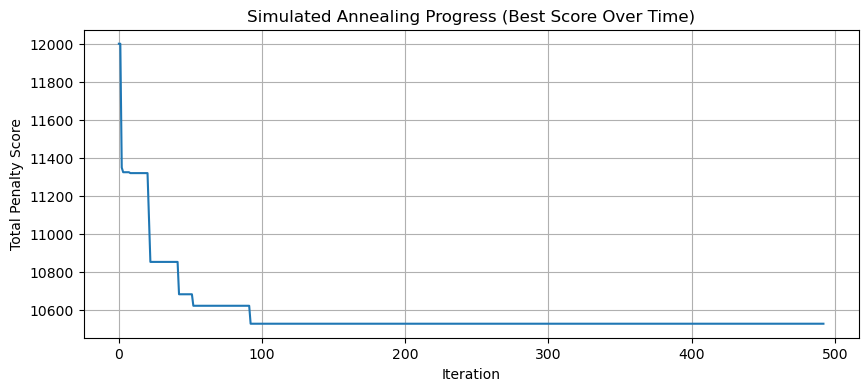


--- Best Bed Allocation Found by Optimizer ---
  Ward A: 51 beds
  Ward B: 32 beds
  Ward C: 19 beds
  Ward D: 15 beds
  Ward E: 13 beds
  Ward F: 35 beds

Minimum Average Penalty Found during optimization: 10526.67
Time Taken for optimization: 48.75 seconds

--- Verifying performance of best configuration with long, stable runs ---
  Verification Run - Final Average Penalty Score: 23973.20
  Verification Run - Ward F Average Admission Rate: 95.92%


In [ ]:
# New algorithm

import numpy as np
import random
import heapq
import matplotlib.pyplot as plt
import time

# ==============================================================================
# PART 1: The Core Simulation Model
# ==============================================================================
# This class represents the hospital and contains all the rules for patient flow.

class HospitalModel:
    """Represents the hospital's rules, state, and statistics for a single simulation run."""
    def __init__(self, bed_config):
        # --- Static Parameters (The "Rules") ---
        self.wards = list(bed_config.keys())
        self.capacities = bed_config.copy()
        self.arrival_rates = {'A': 14.5, 'B': 11.0, 'C': 8.0, 'D': 6.5, 'E': 5.0, 'F': 13.0}
        self.mean_stays = {'A': 2.9, 'B': 4.0, 'C': 4.5, 'D': 1.4, 'E': 3.9, 'F': 2.2}
        self.urgency_points = {'A': 7, 'B': 5, 'C': 2, 'D': 10, 'E': 5, 'F': 0}
        self.reloc_probs = {
            'A': {'B': 0.05, 'C': 0.10, 'D': 0.05, 'E': 0.80},
            'B': {'A': 0.20, 'C': 0.50, 'D': 0.15, 'E': 0.15},
            'C': {'A': 0.30, 'B': 0.20, 'D': 0.20, 'E': 0.30},
            'D': {'A': 0.35, 'B': 0.30, 'C': 0.05, 'E': 0.30},
            'E': {'A': 0.20, 'B': 0.10, 'C': 0.60, 'D': 0.10},
            'F': {'A': 0.20, 'B': 0.20, 'C': 0.20, 'D': 0.20, 'E': 0.20}
        }
        
        # --- Dynamic State Variables (What changes during simulation) ---
        self.occupied_beds = {w: 0 for w in self.wards}
        self.stats = {
            'total_arrivals': {w: 0 for w in self.wards},
            'primary_admissions': {w: 0 for w in self.wards},
            'relocated_from': {w: 0 for w in self.wards},
            'lost_patients': {w: 0 for w in self.wards}
        }

    def handle_arrival(self, patient_type):
        """Handles a patient arrival and returns the ward they were admitted to (or None)."""
        self.stats['total_arrivals'][patient_type] += 1
        
        if self.occupied_beds[patient_type] < self.capacities[patient_type]:
            self.occupied_beds[patient_type] += 1
            self.stats['primary_admissions'][patient_type] += 1
            return patient_type
        else:
            self.stats['relocated_from'][patient_type] += 1
            reloc_options = self.reloc_probs.get(patient_type, {})
            if not reloc_options:
                self.stats['lost_patients'][patient_type] += 1
                return None
            wards, probs = zip(*reloc_options.items())
            alt_ward = np.random.choice(wards, p=probs)
            
            if self.occupied_beds[alt_ward] < self.capacities[alt_ward]:
                self.occupied_beds[alt_ward] += 1
                return alt_ward
            else:
                self.stats['lost_patients'][patient_type] += 1
                return None

    def handle_departure(self, ward_of_admission):
        if self.occupied_beds[ward_of_admission] > 0:
            self.occupied_beds[ward_of_admission] -= 1

def simulate_hospital_flow(bed_config, duration=365, burn_in=60):
    """The main simulation function used to evaluate a bed configuration."""
    model = HospitalModel(bed_config)
    event_list = []
    current_time = 0.0

    def schedule_event(delay, event_type, details):
        heapq.heappush(event_list, (current_time + delay, event_type, details))

    for p_type in model.wards:
        if p_type in model.arrival_rates:
            delay = np.random.exponential(1.0 / model.arrival_rates[p_type])
            schedule_event(delay, 'ARRIVAL', {'patient_type': p_type})

    while event_list and current_time < duration:
        time, event_type, details = heapq.heappop(event_list)
        current_time = time

        if event_type == 'ARRIVAL':
            p_type = details['patient_type']
            delay = np.random.exponential(1.0 / model.arrival_rates[p_type])
            schedule_event(delay, 'ARRIVAL', {'patient_type': p_type})
            
            if current_time > burn_in:
                ward_admitted = model.handle_arrival(p_type)
                if ward_admitted:
                    stay = np.random.exponential(model.mean_stays[p_type])
                    schedule_event(stay, 'DEPARTURE', {'ward': ward_admitted})
        
        elif event_type == 'DEPARTURE':
            if current_time > burn_in:
                model.handle_departure(details['ward'])

    total_penalty = sum(model.urgency_points[w] * model.stats['relocated_from'][w] for w in model.wards if w != 'F')
    f_arrivals = model.stats['total_arrivals'].get('F', 0)
    f_admissions = model.stats['primary_admissions'].get('F', 0)
    f_admission_rate = (f_admissions / f_arrivals) if f_arrivals > 0 else 1.0

    return f_admission_rate, total_penalty

# ==============================================================================
# PART 2: The Simulated Annealing Optimizer
# ==============================================================================

def objective_function(bed_config, n_runs=3):
    """
    IMPROVEMENT 1: The objective function is now more robust. It runs the 
    simulation multiple times and averages the results to get a more stable, 
    less noisy cost estimate for the optimizer to use.
    """
    penalties, f_rates = [], []
    for _ in range(n_runs):
        f_rate, penalty = simulate_hospital_flow(bed_config, duration=180, burn_in=30)
        penalties.append(penalty)
        f_rates.append(f_rate)

    avg_penalty = np.mean(penalties)
    avg_f_rate = np.mean(f_rates)

    if avg_f_rate < 0.95:
        avg_penalty += 100000 
    return avg_penalty

def generate_neighbor(config, src_weights):
    """
    IMPROVEMENT 2: The logic for generating a new solution to test is balanced.
    It intelligently chooses a source ward to take a bed FROM (preferring low
    urgency), but chooses the destination randomly. This provides a good
    mix of guided search and random exploration to avoid getting stuck.
    """
    config = config.copy()
    
    valid_sources = {w: weight for w, weight in src_weights.items() if config[w] > 0}
    if not valid_sources: return config
    
    wards, weights = zip(*valid_sources.items())
    src = np.random.choice(wards, p=[w/sum(weights) for w in weights])

    dst_candidates = [w for w in config.keys() if w != src]
    dst = random.choice(dst_candidates)

    config[src] -= 1
    config[dst] += 1
    return config

def simulated_annealing_optimizer(initial_config, src_weights, max_iter=2500):
    """
    The main simulated annealing algorithm with parameters tuned for better results.
    """
    current_config = initial_config.copy()
    # Use more runs for a stable initial cost
    current_cost = objective_function(current_config, n_runs=5) 
    
    best_config = current_config.copy()
    best_cost = current_cost
    cost_history = [current_cost]
    
    # IMPROVEMENT 3: Annealing parameters are tuned for a more thorough search.
    patience = 400
    stall_counter = 0
    T0 = 100.0  # Start hotter to explore more widely at the beginning.
    T_end = 0.1   # Cool down further to fine-tune the solution at the end.

    for k in range(1, max_iter + 1):
        T = T0 * (T_end / T0) ** (k / max_iter)
        
        neighbor = generate_neighbor(current_config, src_weights)
        cost = objective_function(neighbor, n_runs=3) 
        
        delta = cost - current_cost
        
        # Metropolis acceptance criterion
        if delta < 0 or (T > 0 and random.random() < np.exp(-delta / T)):
            current_config = neighbor
            current_cost = cost
        
        # Track the best configuration found so far
        if current_cost < best_cost:
            best_config = current_config.copy()
            best_cost = current_cost
            stall_counter = 0
        else:
            stall_counter += 1
        
        # We track the best_cost found so far for the plot, which gives a smoother line
        cost_history.append(best_cost)
        
        if stall_counter >= patience:
            print(f"Stopping early at iteration {k} after {patience} iterations without improvement.")
            break
            
    plt.figure(figsize=(10,4))
    plt.plot(cost_history)
    plt.title("Simulated Annealing Progress (Best Score Over Time)")
    plt.xlabel("Iteration")
    plt.ylabel("Total Penalty Score")
    plt.grid(True)
    plt.show()

    return best_config, best_cost

# ==============================================================================
# PART 3: Main Execution Block
# ==============================================================================

random.seed(42)
np.random.seed(42)

WARDS = ['A', 'B', 'C', 'D', 'E', 'F']
urgency_points = {'A': 7, 'B': 5, 'C': 2, 'D': 10, 'E': 5, 'F': 0}
# Create weights for choosing a source ward (prefer to take from low urgency)
src_weights = {w: 1 / urgency_points[w] for w in WARDS if w != 'F'}

# --- Set Initial Configuration ---
# Your requested starting point
initial_beds = {'A': 48, 'B': 33, 'C': 23, 'D': 14, 'E': 13, 'F': 34}
print(f"Initial bed configuration: {initial_beds}")
print(f"Total beds: {sum(initial_beds.values())}")

# --- Calculate Initial Penalty for comparison ---
print("\nCalculating initial penalty score for starting configuration...")
initial_penalties = [simulate_hospital_flow(initial_beds, duration=365, burn_in=60)[1] for _ in range(10)]
print(f"  Initial configuration's average annual penalty: {np.mean(initial_penalties):.2f}")

# --- Run the Optimizer ---
print("\nStarting optimization process...")
start_time = time.time()
best_config, best_cost = simulated_annealing_optimizer(initial_beds, src_weights)
end_time = time.time()

# --- Report Final Results ---
print("\n--- Best Bed Allocation Found by Optimizer ---")
for ward in WARDS:
    print(f"  Ward {ward}: {best_config[ward]} beds")

print(f"\nMinimum Average Penalty Found during optimization: {best_cost:.2f}")
print(f"Time Taken for optimization: {end_time - start_time:.2f} seconds")

print("\n--- Verifying performance of best configuration with long, stable runs ---")
final_penalties = []
final_f_rates = []
for _ in range(10): 
    f_rate, penalty = simulate_hospital_flow(best_config, duration=365, burn_in=60)
    final_penalties.append(penalty)
    final_f_rates.append(f_rate)

print(f"  Verification Run - Final Average Penalty Score: {np.mean(final_penalties):.2f}")
print(f"  Verification Run - Ward F Average Admission Rate: {np.mean(final_f_rates):.2%}")


Initial bed configuration: {'A': 48, 'B': 33, 'C': 23, 'D': 14, 'E': 13, 'F': 34}
Total beds: 165

Calculating initial penalty score for starting configuration...
  Initial configuration's average annual penalty: 25013.80

Starting optimization process...
Stopping early at iteration 492 after 400 iterations without improvement.


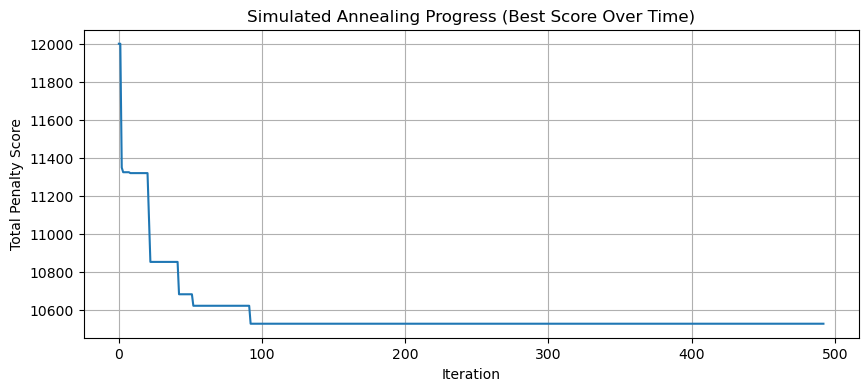


--- Best Bed Allocation Found by Optimizer ---
  Ward A: 51 beds
  Ward B: 32 beds
  Ward C: 19 beds
  Ward D: 15 beds
  Ward E: 13 beds
  Ward F: 35 beds

Minimum Average Penalty Found during optimization: 10526.67
Time Taken for optimization: 49.65 seconds

--- Verifying performance of best configuration ---
  Verification Run - Final Average Penalty Score: 23973.20
  Verification Run - Ward F Average Admission Rate: 95.92%


In [ ]:
# Variation 1


import numpy as np
import random
import heapq
import matplotlib.pyplot as plt
import time

# ==============================================================================
# PART 1: The Core Simulation Model
# ==============================================================================
# This class represents the hospital and contains all the rules for patient flow.

class HospitalModel:
    """Represents the hospital's rules, state, and statistics for a single simulation run."""
    def __init__(self, bed_config):
        # --- Static Parameters (The "Rules") ---
        self.wards = list(bed_config.keys())
        self.capacities = bed_config.copy()
        self.arrival_rates = {'A': 14.5, 'B': 11.0, 'C': 8.0, 'D': 6.5, 'E': 5.0, 'F': 13.0}
        self.mean_stays = {'A': 2.9, 'B': 4.0, 'C': 4.5, 'D': 1.4, 'E': 3.9, 'F': 2.2}
        self.urgency_points = {'A': 7, 'B': 5, 'C': 2, 'D': 10, 'E': 5, 'F': 0}
        self.reloc_probs = {
            'A': {'B': 0.05, 'C': 0.10, 'D': 0.05, 'E': 0.80},
            'B': {'A': 0.20, 'C': 0.50, 'D': 0.15, 'E': 0.15},
            'C': {'A': 0.30, 'B': 0.20, 'D': 0.20, 'E': 0.30},
            'D': {'A': 0.35, 'B': 0.30, 'C': 0.05, 'E': 0.30},
            'E': {'A': 0.20, 'B': 0.10, 'C': 0.60, 'D': 0.10},
            'F': {'A': 0.20, 'B': 0.20, 'C': 0.20, 'D': 0.20, 'E': 0.20}
        }
        
        # --- Dynamic State Variables (What changes during simulation) ---
        self.occupied_beds = {w: 0 for w in self.wards}
        self.stats = {
            'total_arrivals': {w: 0 for w in self.wards},
            'primary_admissions': {w: 0 for w in self.wards},
            'relocated_from': {w: 0 for w in self.wards},
            'lost_patients': {w: 0 for w in self.wards}
        }

    def handle_arrival(self, patient_type):
        """Handles a patient arrival and returns the ward they were admitted to (or None)."""
        self.stats['total_arrivals'][patient_type] += 1
        
        if self.occupied_beds[patient_type] < self.capacities[patient_type]:
            self.occupied_beds[patient_type] += 1
            self.stats['primary_admissions'][patient_type] += 1
            return patient_type
        else:
            self.stats['relocated_from'][patient_type] += 1
            reloc_options = self.reloc_probs.get(patient_type, {})
            if not reloc_options:
                self.stats['lost_patients'][patient_type] += 1
                return None
            wards, probs = zip(*reloc_options.items())
            alt_ward = np.random.choice(wards, p=probs)
            
            if self.occupied_beds[alt_ward] < self.capacities[alt_ward]:
                self.occupied_beds[alt_ward] += 1
                return alt_ward
            else:
                self.stats['lost_patients'][patient_type] += 1
                return None

    def handle_departure(self, ward_of_admission):
        if self.occupied_beds[ward_of_admission] > 0:
            self.occupied_beds[ward_of_admission] -= 1

def simulate_hospital_flow(bed_config, duration=365, burn_in=60):
    """The main simulation function used to evaluate a bed configuration."""
    model = HospitalModel(bed_config)
    event_list = []
    current_time = 0.0

    def schedule_event(delay, event_type, details):
        heapq.heappush(event_list, (current_time + delay, event_type, details))

    for p_type in model.wards:
        if p_type in model.arrival_rates:
            delay = np.random.exponential(1.0 / model.arrival_rates[p_type])
            schedule_event(delay, 'ARRIVAL', {'patient_type': p_type})

    while event_list and current_time < duration:
        time, event_type, details = heapq.heappop(event_list)
        current_time = time

        if event_type == 'ARRIVAL':
            p_type = details['patient_type']
            delay = np.random.exponential(1.0 / model.arrival_rates[p_type])
            schedule_event(delay, 'ARRIVAL', {'patient_type': p_type})
            
            if current_time > burn_in:
                ward_admitted = model.handle_arrival(p_type)
                if ward_admitted:
                    stay = np.random.exponential(model.mean_stays[p_type])
                    schedule_event(stay, 'DEPARTURE', {'ward': ward_admitted})
        
        elif event_type == 'DEPARTURE':
            if current_time > burn_in:
                model.handle_departure(details['ward'])

    total_penalty = sum(model.urgency_points[w] * model.stats['relocated_from'][w] for w in model.wards if w != 'F')
    f_arrivals = model.stats['total_arrivals'].get('F', 0)
    f_admissions = model.stats['primary_admissions'].get('F', 0)
    f_admission_rate = (f_admissions / f_arrivals) if f_arrivals > 0 else 1.0

    return f_admission_rate, total_penalty

# ==============================================================================
# PART 2: The Simulated Annealing Optimizer
# ==============================================================================

def objective_function(bed_config, n_runs=3):
    """
    IMPROVEMENT 1: The objective function is now more robust. It runs the 
    simulation multiple times and averages the results to get a more stable, 
    less noisy cost estimate for the optimizer to use.
    """
    penalties, f_rates = [], []
    for _ in range(n_runs):
        # We use a shorter duration here for speed during optimization
        f_rate, penalty = simulate_hospital_flow(bed_config, duration=180, burn_in=30)
        penalties.append(penalty)
        f_rates.append(f_rate)

    avg_penalty = np.mean(penalties)
    avg_f_rate = np.mean(f_rates)

    # Add a massive penalty if the average admission rate for F is too low.
    if avg_f_rate < 0.95:
        avg_penalty += 100000 
    return avg_penalty

def generate_neighbor(config, src_weights):
    """
    IMPROVEMENT 2: The logic for generating a new solution to test is balanced.
    It intelligently chooses a source ward to take a bed FROM (preferring low
    urgency), but chooses the destination randomly. This provides a good
    mix of guided search and random exploration to avoid getting stuck.
    """
    config = config.copy()
    
    valid_sources = {w: weight for w, weight in src_weights.items() if config[w] > 0}
    if not valid_sources: return config
    
    wards, weights = zip(*valid_sources.items())
    src = np.random.choice(wards, p=[w/sum(weights) for w in weights])

    dst_candidates = [w for w in config.keys() if w != src]
    dst = random.choice(dst_candidates)

    config[src] -= 1
    config[dst] += 1
    return config

def simulated_annealing_optimizer(initial_config, src_weights, max_iter=2500):
    """
    The main simulated annealing algorithm with parameters tuned for better results.
    """
    current_config = initial_config.copy()
    # Use more runs for a stable initial cost
    current_cost = objective_function(current_config, n_runs=5) 
    
    best_config = current_config.copy()
    best_cost = current_cost
    cost_history = [current_cost]
    
    # IMPROVEMENT 3: Annealing parameters are tuned for a more thorough search.
    patience = 400
    stall_counter = 0
    T0 = 100.0  # Start hotter to explore more widely at the beginning.
    T_end = 0.1   # Cool down further to fine-tune the solution at the end.

    for k in range(1, max_iter + 1):
        T = T0 * (T_end / T0) ** (k / max_iter)
        
        neighbor = generate_neighbor(current_config, src_weights)
        cost = objective_function(neighbor, n_runs=3) 
        
        delta = cost - current_cost
        
        # Metropolis acceptance criterion
        if delta < 0 or (T > 0 and random.random() < np.exp(-delta / T)):
            current_config = neighbor
            current_cost = cost
        
        # Track the best configuration found so far
        if current_cost < best_cost:
            best_config = current_config.copy()
            best_cost = current_cost
            stall_counter = 0
        else:
            stall_counter += 1
        
        # We track the best_cost found so far for the plot, which gives a smoother line
        cost_history.append(best_cost)
        
        if stall_counter >= patience:
            print(f"Stopping early at iteration {k} after {patience} iterations without improvement.")
            break
            
    plt.figure(figsize=(10,4))
    plt.plot(cost_history)
    plt.title("Simulated Annealing Progress (Best Score Over Time)")
    plt.xlabel("Iteration")
    plt.ylabel("Total Penalty Score")
    plt.grid(True)
    plt.show()

    return best_config, best_cost

# ==============================================================================
# PART 3: Main Execution Block
# ==============================================================================

random.seed(42)
np.random.seed(42)

WARDS = ['A', 'B', 'C', 'D', 'E', 'F']
urgency_points = {'A': 7, 'B': 5, 'C': 2, 'D': 10, 'E': 5, 'F': 0}
# Create weights for choosing a source ward (prefer to take from low urgency)
src_weights = {w: 1 / urgency_points[w] for w in WARDS if w != 'F'}

# --- Set Initial Configuration ---
# Your requested starting point
initial_beds = {'A': 48, 'B': 33, 'C': 23, 'D': 14, 'E': 13, 'F': 34}
print(f"Initial bed configuration: {initial_beds}")
print(f"Total beds: {sum(initial_beds.values())}")

# --- Calculate Initial Penalty for comparison ---
print("\nCalculating initial penalty score for starting configuration...")
initial_penalties = [simulate_hospital_flow(initial_beds, duration=365, burn_in=60)[1] for _ in range(10)]
print(f"  Initial configuration's average annual penalty: {np.mean(initial_penalties):.2f}")

# --- Run the Optimizer ---
print("\nStarting optimization process...")
start_time = time.time()
best_config, best_cost = simulated_annealing_optimizer(initial_beds, src_weights)
end_time = time.time()

# --- Report Final Results ---
print("\n--- Best Bed Allocation Found by Optimizer ---")
for ward in WARDS:
    print(f"  Ward {ward}: {best_config[ward]} beds")

print(f"\nMinimum Average Penalty Found during optimization: {best_cost:.2f}")
print(f"Time Taken for optimization: {end_time - start_time:.2f} seconds")

# --- Verifying performance of best configuration with long, stable runs ---
print("\n--- Verifying performance of best configuration ---")
final_penalties = []
final_f_rates = []
for _ in range(10): 
    f_rate, penalty = simulate_hospital_flow(best_config, duration=365, burn_in=60)
    final_penalties.append(penalty)
    final_f_rates.append(f_rate)

print(f"  Verification Run - Final Average Penalty Score: {np.mean(final_penalties):.2f}")
print(f"  Verification Run - Ward F Average Admission Rate: {np.mean(final_f_rates):.2%}")


Initial bed configuration: {'A': 48, 'B': 33, 'C': 23, 'D': 14, 'E': 13, 'F': 34}
Total beds: 165

Calculating initial penalty score for starting configuration...
  Initial configuration's average annual penalty: 24752.20

Starting optimization process...
Stopping early at iteration 1520 after 500 iterations without improvement.


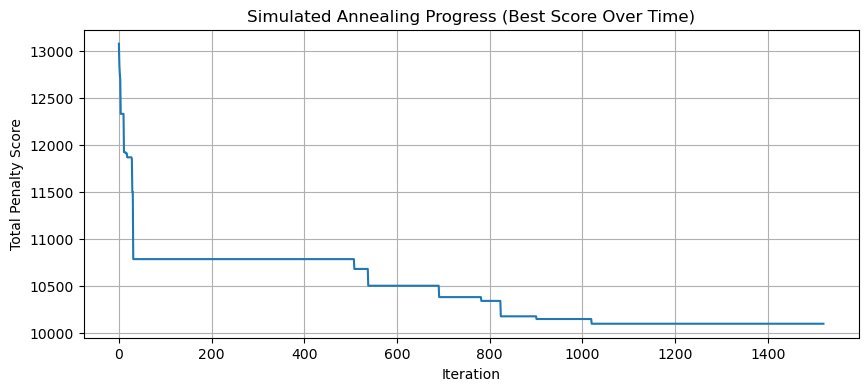


--- Best Bed Allocation Found by Optimizer ---
  Ward A: 53 beds
  Ward B: 36 beds
  Ward C: 10 beds
  Ward D: 22 beds
  Ward E: 8 beds
  Ward F: 36 beds

Minimum Average Penalty Found during optimization: 10101.33
Time Taken for optimization: 163.78 seconds

--- Verifying performance of best configuration ---
  Verification Run - Final Average Penalty Score: 21267.10
  Verification Run - Ward F Average Admission Rate: 97.35%


In [ ]:
#Variation 2
import numpy as np
import random
import heapq
import matplotlib.pyplot as plt
import time

# ==============================================================================
# PART 1: The Core Simulation Model
# ==============================================================================
# This class represents the hospital and contains all the rules for patient flow.

class HospitalModel:
    """Represents the hospital's rules, state, and statistics for a single simulation run."""
    def __init__(self, bed_config):
        self.wards = list(bed_config.keys())
        self.capacities = bed_config.copy()
        self.arrival_rates = {'A': 14.5, 'B': 11.0, 'C': 8.0, 'D': 6.5, 'E': 5.0, 'F': 13.0}
        self.mean_stays = {'A': 2.9, 'B': 4.0, 'C': 4.5, 'D': 1.4, 'E': 3.9, 'F': 2.2}
        self.urgency_points = {'A': 7, 'B': 5, 'C': 2, 'D': 10, 'E': 5, 'F': 0}
        self.reloc_probs = {
            'A': {'B': 0.05, 'C': 0.10, 'D': 0.05, 'E': 0.80},
            'B': {'A': 0.20, 'C': 0.50, 'D': 0.15, 'E': 0.15},
            'C': {'A': 0.30, 'B': 0.20, 'D': 0.20, 'E': 0.30},
            'D': {'A': 0.35, 'B': 0.30, 'C': 0.05, 'E': 0.30},
            'E': {'A': 0.20, 'B': 0.10, 'C': 0.60, 'D': 0.10},
            'F': {'A': 0.20, 'B': 0.20, 'C': 0.20, 'D': 0.20, 'E': 0.20}
        }
        
        self.occupied_beds = {w: 0 for w in self.wards}
        self.stats = {
            'total_arrivals': {w: 0 for w in self.wards},
            'primary_admissions': {w: 0 for w in self.wards},
            'relocated_from': {w: 0 for w in self.wards},
            'lost_patients': {w: 0 for w in self.wards}
        }

    def handle_arrival(self, patient_type):
        """Handles a patient arrival and returns the ward they were admitted to (or None)."""
        self.stats['total_arrivals'][patient_type] += 1
        
        if self.occupied_beds[patient_type] < self.capacities[patient_type]:
            self.occupied_beds[patient_type] += 1
            self.stats['primary_admissions'][patient_type] += 1
            return patient_type
        else:
            self.stats['relocated_from'][patient_type] += 1
            reloc_options = self.reloc_probs.get(patient_type, {})
            if not reloc_options:
                self.stats['lost_patients'][patient_type] += 1
                return None
            wards, probs = zip(*reloc_options.items())
            alt_ward = np.random.choice(wards, p=probs)
            
            if self.occupied_beds[alt_ward] < self.capacities[alt_ward]:
                self.occupied_beds[alt_ward] += 1
                return alt_ward
            else:
                self.stats['lost_patients'][patient_type] += 1
                return None

    def handle_departure(self, ward_of_admission):
        if self.occupied_beds[ward_of_admission] > 0:
            self.occupied_beds[ward_of_admission] -= 1

def simulate_hospital_flow(bed_config, duration=365, burn_in=60):
    """The main simulation function used to evaluate a bed configuration."""
    model = HospitalModel(bed_config)
    event_list = []
    current_time = 0.0

    def schedule_event(delay, event_type, details):
        heapq.heappush(event_list, (current_time + delay, event_type, details))

    for p_type in model.wards:
        if p_type in model.arrival_rates:
            delay = np.random.exponential(1.0 / model.arrival_rates[p_type])
            schedule_event(delay, 'ARRIVAL', {'patient_type': p_type})

    while event_list and current_time < duration:
        time, event_type, details = heapq.heappop(event_list)
        current_time = time

        if event_type == 'ARRIVAL':
            p_type = details['patient_type']
            delay = np.random.exponential(1.0 / model.arrival_rates[p_type])
            schedule_event(delay, 'ARRIVAL', {'patient_type': p_type})
            
            if current_time > burn_in:
                ward_admitted = model.handle_arrival(p_type)
                if ward_admitted:
                    stay = np.random.exponential(model.mean_stays[p_type])
                    schedule_event(stay, 'DEPARTURE', {'ward': ward_admitted})
        
        elif event_type == 'DEPARTURE':
            if current_time > burn_in:
                model.handle_departure(details['ward'])

    total_penalty = sum(model.urgency_points[w] * model.stats['relocated_from'][w] for w in model.wards if w != 'F')
    f_arrivals = model.stats['total_arrivals'].get('F', 0)
    f_admissions = model.stats['primary_admissions'].get('F', 0)
    f_admission_rate = (f_admissions / f_arrivals) if f_arrivals > 0 else 1.0

    return f_admission_rate, total_penalty

# ==============================================================================
# PART 2: The Simulated Annealing Optimizer
# ==============================================================================

def objective_function(bed_config, n_runs=3):
    """
    IMPROVEMENT 1: The objective function is now more robust. It runs the 
    simulation multiple times and averages the results to get a more stable, 
    less noisy cost estimate for the optimizer to use.
    """
    penalties, f_rates = [], []
    for _ in range(n_runs):
        # We use a shorter duration here for speed during optimization
        f_rate, penalty = simulate_hospital_flow(bed_config, duration=200, burn_in=40)
        penalties.append(penalty)
        f_rates.append(f_rate)

    avg_penalty = np.mean(penalties)
    avg_f_rate = np.mean(f_rates)

    # Add a massive penalty if the average admission rate for F is too low.
    if avg_f_rate < 0.95:
        avg_penalty += 100000 
    return avg_penalty

def generate_neighbor(config, src_weights):
    """
    IMPROVEMENT 2: The logic for generating a new solution to test is balanced.
    It intelligently chooses a source ward to take a bed FROM (preferring low
    urgency), but chooses the destination randomly. This provides a good
    mix of guided search and random exploration to avoid getting stuck.
    """
    config = config.copy()
    
    valid_sources = {w: weight for w, weight in src_weights.items() if config[w] > 0}
    if not valid_sources: return config
    
    wards, weights = zip(*valid_sources.items())
    src = np.random.choice(wards, p=[w/sum(weights) for w in weights])

    dst_candidates = [w for w in config.keys() if w != src]
    dst = random.choice(dst_candidates)

    config[src] -= 1
    config[dst] += 1
    return config

def simulated_annealing_optimizer(initial_config, src_weights, max_iter=3000):
    """
    The main simulated annealing algorithm with parameters tuned for better results.
    """
    current_config = initial_config.copy()
    # Use more runs for a stable initial cost
    current_cost = objective_function(current_config, n_runs=5) 
    
    best_config = current_config.copy()
    best_cost = current_cost
    cost_history = [current_cost]
    
    # IMPROVEMENT 3: Annealing parameters are tuned for a more thorough search.
    patience = 500
    stall_counter = 0
    T0 = 150.0  # Start hotter to explore more widely at the beginning.
    T_end = 0.1   # Cool down further to fine-tune the solution at the end.

    for k in range(1, max_iter + 1):
        T = T0 * (T_end / T0) ** (k / max_iter)
        
        neighbor = generate_neighbor(current_config, src_weights)
        cost = objective_function(neighbor, n_runs=3) 
        
        delta = cost - current_cost
        
        # Metropolis acceptance criterion
        if delta < 0 or (T > 0 and random.random() < np.exp(-delta / T)):
            current_config = neighbor
            current_cost = cost
        
        # Track the best configuration found so far
        if current_cost < best_cost:
            best_config = current_config.copy()
            best_cost = current_cost
            stall_counter = 0
        else:
            stall_counter += 1
        
        # We track the best_cost found so far for the plot, which gives a smoother line
        cost_history.append(best_cost)
        
        if stall_counter >= patience:
            print(f"Stopping early at iteration {k} after {patience} iterations without improvement.")
            break
            
    plt.figure(figsize=(10,4))
    plt.plot(cost_history)
    plt.title("Simulated Annealing Progress (Best Score Over Time)")
    plt.xlabel("Iteration")
    plt.ylabel("Total Penalty Score")
    plt.grid(True)
    plt.show()

    return best_config, best_cost

# ==============================================================================
# PART 3: Main Execution Block
# ==============================================================================

random.seed(0)
np.random.seed(0)

WARDS = ['A', 'B', 'C', 'D', 'E', 'F']
urgency_points = {'A': 7, 'B': 5, 'C': 2, 'D': 10, 'E': 5, 'F': 0}
# Create weights for choosing a source ward (prefer to take from low urgency)
src_weights = {w: 1 / urgency_points[w] for w in WARDS if w != 'F'}

# --- Set Initial Configuration as requested ---
initial_beds = {'A': 48, 'B': 33, 'C': 23, 'D': 14, 'E': 13, 'F': 34}
print(f"Initial bed configuration: {initial_beds}")
print(f"Total beds: {sum(initial_beds.values())}")

# --- Calculate Initial Penalty for comparison ---
print("\nCalculating initial penalty score for starting configuration...")
initial_penalties = [simulate_hospital_flow(initial_beds, duration=365, burn_in=60)[1] for _ in range(10)]
print(f"  Initial configuration's average annual penalty: {np.mean(initial_penalties):.2f}")

# --- Run the Optimizer ---
print("\nStarting optimization process...")
start_time = time.time()
best_config, best_cost = simulated_annealing_optimizer(initial_beds, src_weights)
end_time = time.time()

# --- Report Final Results ---
print("\n--- Best Bed Allocation Found by Optimizer ---")
for ward in WARDS:
    print(f"  Ward {ward}: {best_config[ward]} beds")

print(f"\nMinimum Average Penalty Found during optimization: {best_cost:.2f}")
print(f"Time Taken for optimization: {end_time - start_time:.2f} seconds")

# --- Verifying performance of best configuration with long, stable runs ---
print("\n--- Verifying performance of best configuration ---")
final_penalties = []
final_f_rates = []
for _ in range(10): 
    f_rate, penalty = simulate_hospital_flow(best_config, duration=365, burn_in=60)
    final_penalties.append(penalty)
    final_f_rates.append(f_rate)

print(f"  Verification Run - Final Average Penalty Score: {np.mean(final_penalties):.2f}")
print(f"  Verification Run - Ward F Average Admission Rate: {np.mean(final_f_rates):.2%}")


Initial bed configuration: {'A': 48, 'B': 33, 'C': 23, 'D': 14, 'E': 13, 'F': 34}
Total beds: 165

Calculating initial penalty score for starting configuration...
  Initial configuration's average annual penalty: 25013.80

Starting optimization process...
Stopping early at iteration 569 after 500 iterations without improvement.


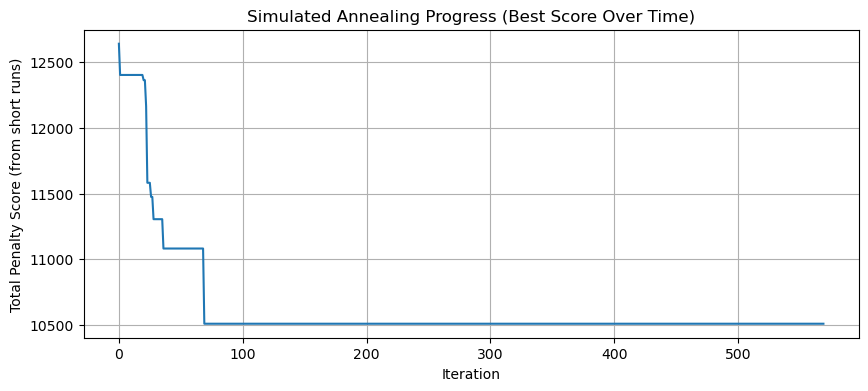


--- Best Bed Allocation Found by Optimizer ---
  Ward A: 50 beds
  Ward B: 34 beds
  Ward C: 12 beds
  Ward D: 21 beds
  Ward E: 12 beds
  Ward F: 36 beds

Minimum Average Penalty Found during optimization: 10510.33
Time Taken for optimization: 62.98 seconds

--- Verifying performance of best configuration ---
  Verification Run - Final Average Penalty Score: 22139.30
  Verification Run - Ward F Average Admission Rate: 97.46%


In [ ]:
# Variation 3
import numpy as np
import random
import heapq
import matplotlib.pyplot as plt
import time

# ==============================================================================
# PART 1: The Core Simulation Model
# ==============================================================================
# This class represents the hospital and contains all the rules for patient flow.

class HospitalModel:
    """Represents the hospital's rules, state, and statistics for a single simulation run."""
    def __init__(self, bed_config):
        self.wards = list(bed_config.keys())
        self.capacities = bed_config.copy()
        self.arrival_rates = {'A': 14.5, 'B': 11.0, 'C': 8.0, 'D': 6.5, 'E': 5.0, 'F': 13.0}
        self.mean_stays = {'A': 2.9, 'B': 4.0, 'C': 4.5, 'D': 1.4, 'E': 3.9, 'F': 2.2}
        self.urgency_points = {'A': 7, 'B': 5, 'C': 2, 'D': 10, 'E': 5, 'F': 0}
        self.reloc_probs = {
            'A': {'B': 0.05, 'C': 0.10, 'D': 0.05, 'E': 0.80},
            'B': {'A': 0.20, 'C': 0.50, 'D': 0.15, 'E': 0.15},
            'C': {'A': 0.30, 'B': 0.20, 'D': 0.20, 'E': 0.30},
            'D': {'A': 0.35, 'B': 0.30, 'C': 0.05, 'E': 0.30},
            'E': {'A': 0.20, 'B': 0.10, 'C': 0.60, 'D': 0.10},
            'F': {'A': 0.20, 'B': 0.20, 'C': 0.20, 'D': 0.20, 'E': 0.20}
        }
        
        self.occupied_beds = {w: 0 for w in self.wards}
        self.stats = {
            'total_arrivals': {w: 0 for w in self.wards},
            'primary_admissions': {w: 0 for w in self.wards},
            'relocated_from': {w: 0 for w in self.wards},
            'lost_patients': {w: 0 for w in self.wards}
        }

    def handle_arrival(self, patient_type):
        """Handles a patient arrival and returns the ward they were admitted to (or None)."""
        self.stats['total_arrivals'][patient_type] += 1
        
        if self.occupied_beds[patient_type] < self.capacities[patient_type]:
            self.occupied_beds[patient_type] += 1
            self.stats['primary_admissions'][patient_type] += 1
            return patient_type
        else:
            self.stats['relocated_from'][patient_type] += 1
            reloc_options = self.reloc_probs.get(patient_type, {})
            if not reloc_options:
                self.stats['lost_patients'][patient_type] += 1
                return None
            wards, probs = zip(*reloc_options.items())
            alt_ward = np.random.choice(wards, p=probs)
            
            if self.occupied_beds[alt_ward] < self.capacities[alt_ward]:
                self.occupied_beds[alt_ward] += 1
                return alt_ward
            else:
                self.stats['lost_patients'][patient_type] += 1
                return None

    def handle_departure(self, ward_of_admission):
        if self.occupied_beds[ward_of_admission] > 0:
            self.occupied_beds[ward_of_admission] -= 1

def simulate_hospital_flow(bed_config, duration=365, burn_in=60):
    """The main simulation function used to evaluate a bed configuration."""
    model = HospitalModel(bed_config)
    event_list = []
    current_time = 0.0

    def schedule_event(delay, event_type, details):
        heapq.heappush(event_list, (current_time + delay, event_type, details))

    for p_type in model.wards:
        if p_type in model.arrival_rates:
            delay = np.random.exponential(1.0 / model.arrival_rates[p_type])
            schedule_event(delay, 'ARRIVAL', {'patient_type': p_type})

    while event_list and current_time < duration:
        time, event_type, details = heapq.heappop(event_list)
        current_time = time

        if event_type == 'ARRIVAL':
            p_type = details['patient_type']
            delay = np.random.exponential(1.0 / model.arrival_rates[p_type])
            schedule_event(delay, 'ARRIVAL', {'patient_type': p_type})
            
            if current_time > burn_in:
                ward_admitted = model.handle_arrival(p_type)
                if ward_admitted:
                    stay = np.random.exponential(model.mean_stays[p_type])
                    schedule_event(stay, 'DEPARTURE', {'ward': ward_admitted})
        
        elif event_type == 'DEPARTURE':
            if current_time > burn_in:
                model.handle_departure(details['ward'])

    total_penalty = sum(model.urgency_points[w] * model.stats['relocated_from'][w] for w in model.wards if w != 'F')
    f_arrivals = model.stats['total_arrivals'].get('F', 0)
    f_admissions = model.stats['primary_admissions'].get('F', 0)
    f_admission_rate = (f_admissions / f_arrivals) if f_arrivals > 0 else 1.0

    return f_admission_rate, total_penalty

# ==============================================================================
# PART 2: The Simulated Annealing Optimizer
# ==============================================================================

def objective_function(bed_config, n_runs=3):
    """
    IMPROVEMENT 1: The objective function is now more robust. It runs the 
    simulation multiple times and averages the results to get a more stable, 
    less noisy cost estimate for the optimizer to use.
    """
    penalties, f_rates = [], []
    for _ in range(n_runs):
        # We use a shorter duration here for speed during optimization
        f_rate, penalty = simulate_hospital_flow(bed_config, duration=200, burn_in=40)
        penalties.append(penalty)
        f_rates.append(f_rate)

    avg_penalty = np.mean(penalties)
    avg_f_rate = np.mean(f_rates)

    # Add a massive penalty if the average admission rate for F is too low.
    if avg_f_rate < 0.95:
        avg_penalty += 100000 
    return avg_penalty

def generate_neighbor(config, src_weights):
    """
    IMPROVEMENT 2: The logic for generating a new solution to test is balanced.
    It intelligently chooses a source ward to take a bed FROM (preferring low
    urgency), but chooses the destination randomly. This provides a good
    mix of guided search and random exploration to avoid getting stuck.
    """
    config = config.copy()
    
    valid_sources = {w: weight for w, weight in src_weights.items() if config[w] > 0}
    if not valid_sources: return config
    
    wards, weights = zip(*valid_sources.items())
    src = np.random.choice(wards, p=[w/sum(weights) for w in weights])

    dst_candidates = [w for w in config.keys() if w != src]
    dst = random.choice(dst_candidates)

    config[src] -= 1
    config[dst] += 1
    return config

def simulated_annealing_optimizer(initial_config, src_weights, max_iter=3000):
    """
    The main simulated annealing algorithm with parameters tuned for better results.
    """
    current_config = initial_config.copy()
    # Use more runs for a stable initial cost
    current_cost = objective_function(current_config, n_runs=5) 
    
    best_config = current_config.copy()
    best_cost = current_cost
    cost_history = [current_cost]
    
    # IMPROVEMENT 3: Annealing parameters are tuned for a more thorough search.
    patience = 500
    stall_counter = 0
    T0 = 150.0  # Start hotter to explore more widely at the beginning.
    T_end = 0.1   # Cool down further to fine-tune the solution at the end.

    for k in range(1, max_iter + 1):
        T = T0 * (T_end / T0) ** (k / max_iter)
        
        neighbor = generate_neighbor(current_config, src_weights)
        cost = objective_function(neighbor, n_runs=3) 
        
        delta = cost - current_cost
        
        # Metropolis acceptance criterion
        if delta < 0 or (T > 0 and random.random() < np.exp(-delta / T)):
            current_config = neighbor
            current_cost = cost
        
        # Track the best configuration found so far
        if current_cost < best_cost:
            best_config = current_config.copy()
            best_cost = current_cost
            stall_counter = 0
        else:
            stall_counter += 1
        
        # We track the best_cost found so far for the plot, which gives a smoother line
        cost_history.append(best_cost)
        
        if stall_counter >= patience:
            print(f"Stopping early at iteration {k} after {patience} iterations without improvement.")
            break
            
    plt.figure(figsize=(10,4))
    plt.plot(cost_history)
    plt.title("Simulated Annealing Progress (Best Score Over Time)")
    plt.xlabel("Iteration")
    plt.ylabel("Total Penalty Score (from short runs)")
    plt.grid(True)
    plt.show()

    return best_config, best_cost

# ==============================================================================
# PART 3: Main Execution Block
# ==============================================================================

random.seed(42)
np.random.seed(42)

WARDS = ['A', 'B', 'C', 'D', 'E', 'F']
urgency_points = {'A': 7, 'B': 5, 'C': 2, 'D': 10, 'E': 5, 'F': 0}
# Create weights for choosing a source ward (prefer to take from low urgency)
src_weights = {w: 1 / urgency_points[w] for w in WARDS if w != 'F'}

# --- Set Initial Configuration as requested ---
initial_beds = {'A': 48, 'B': 33, 'C': 23, 'D': 14, 'E': 13, 'F': 34}
print(f"Initial bed configuration: {initial_beds}")
print(f"Total beds: {sum(initial_beds.values())}")

# --- Calculate Initial Penalty for comparison ---
print("\nCalculating initial penalty score for starting configuration...")
initial_penalties = [simulate_hospital_flow(initial_beds, duration=365, burn_in=60)[1] for _ in range(10)]
print(f"  Initial configuration's average annual penalty: {np.mean(initial_penalties):.2f}")

# --- Run the Optimizer ---
print("\nStarting optimization process...")
start_time = time.time()
best_config, best_cost = simulated_annealing_optimizer(initial_beds, src_weights)
end_time = time.time()

# --- Report Final Results ---
print("\n--- Best Bed Allocation Found by Optimizer ---")
for ward in WARDS:
    print(f"  Ward {ward}: {best_config[ward]} beds")

print(f"\nMinimum Average Penalty Found during optimization: {best_cost:.2f}")
print(f"Time Taken for optimization: {end_time - start_time:.2f} seconds")

# --- Verifying performance of best configuration with long, stable runs ---
print("\n--- Verifying performance of best configuration ---")
final_penalties = []
final_f_rates = []
for _ in range(10): 
    f_rate, penalty = simulate_hospital_flow(best_config, duration=365, burn_in=60)
    final_penalties.append(penalty)
    final_f_rates.append(f_rate)

print(f"  Verification Run - Final Average Penalty Score: {np.mean(final_penalties):.2f}")
print(f"  Verification Run - Ward F Average Admission Rate: {np.mean(final_f_rates):.2%}")


In [ ]:
#Last try
import numpy as np
import random
import heapq
import matplotlib.pyplot as plt
import time

# ==============================================================================
# PART 1: The Core Simulation Model (The "Scoring Engine")
# ==============================================================================
class HospitalModel:
    """Represents the hospital's rules, state, and statistics for a single simulation run."""
    def __init__(self, bed_config):
        self.wards = list(bed_config.keys())
        self.capacities = bed_config.copy()
        self.arrival_rates = {'A': 14.5, 'B': 11.0, 'C': 8.0, 'D': 6.5, 'E': 5.0, 'F': 13.0}
        self.mean_stays = {'A': 2.9, 'B': 4.0, 'C': 4.5, 'D': 1.4, 'E': 3.9, 'F': 2.2}
        self.urgency_points = {'A': 7, 'B': 5, 'C': 2, 'D': 10, 'E': 5, 'F': 0}
        self.reloc_probs = {
            'A': {'B': 0.05, 'C': 0.10, 'D': 0.05, 'E': 0.80},
            'B': {'A': 0.20, 'C': 0.50, 'D': 0.15, 'E': 0.15},
            'C': {'A': 0.30, 'B': 0.20, 'D': 0.20, 'E': 0.30},
            'D': {'A': 0.35, 'B': 0.30, 'C': 0.05, 'E': 0.30},
            'E': {'A': 0.20, 'B': 0.10, 'C': 0.60, 'D': 0.10},
            'F': {'A': 0.20, 'B': 0.20, 'C': 0.20, 'D': 0.20, 'E': 0.20}
        }
        self.occupied_beds = {w: 0 for w in self.wards}
        self.stats = {'total_arrivals': {w: 0 for w in self.wards}, 'primary_admissions': {w: 0 for w in self.wards}, 'relocated_from': {w: 0 for w in self.wards}}

    def handle_arrival(self, patient_type):
        self.stats['total_arrivals'][patient_type] += 1
        if self.occupied_beds[patient_type] < self.capacities[patient_type]:
            self.occupied_beds[patient_type] += 1
            self.stats['primary_admissions'][patient_type] += 1
            return patient_type
        else:
            self.stats['relocated_from'][patient_type] += 1
            reloc_options = self.reloc_probs.get(patient_type, {})
            if not reloc_options: return None
            wards, probs = zip(*reloc_options.items())
            alt_ward = np.random.choice(wards, p=probs)
            if self.occupied_beds[alt_ward] < self.capacities[alt_ward]:
                self.occupied_beds[alt_ward] += 1
                return alt_ward
            return None

    def handle_departure(self, ward_of_admission):
        if self.occupied_beds[ward_of_admission] > 0:
            self.occupied_beds[ward_of_admission] -= 1

def simulate_hospital_flow(bed_config, duration=365, burn_in=60):
    model = HospitalModel(bed_config)
    event_list = []
    current_time = 0.0
    def schedule_event(delay, event_type, details): heapq.heappush(event_list, (current_time + delay, event_type, details))
    for p_type in model.wards:
        if p_type in model.arrival_rates: schedule_event(np.random.exponential(1.0 / model.arrival_rates[p_type]), 'ARRIVAL', {'patient_type': p_type})
    while event_list and current_time < duration:
        time, event_type, details = heapq.heappop(event_list)
        current_time = time
        if event_type == 'ARRIVAL':
            p_type = details['patient_type']
            schedule_event(np.random.exponential(1.0 / model.arrival_rates[p_type]), 'ARRIVAL', {'patient_type': p_type})
            if current_time > burn_in:
                ward_admitted = model.handle_arrival(p_type)
                if ward_admitted: schedule_event(np.random.exponential(model.mean_stays[p_type]), 'DEPARTURE', {'ward': ward_admitted})
        elif event_type == 'DEPARTURE':
            if current_time > burn_in: model.handle_departure(details['ward'])
    total_penalty = sum(model.urgency_points[w] * model.stats['relocated_from'][w] for w in model.wards if w != 'F')
    f_admissions = model.stats['primary_admissions'].get('F', 0)
    f_arrivals = model.stats['total_arrivals'].get('F', 0)
    return (f_admissions / f_arrivals) if f_arrivals > 0 else 1.0, total_penalty

# ==============================================================================
# PART 2: The Hybrid Optimization Framework
# ==============================================================================

def objective_function(bed_config, n_runs=3):
    """Runs multiple simulations to get a stable cost for a given bed layout."""
    penalties, f_rates = [], []
    for _ in range(n_runs):
        f_rate, penalty = simulate_hospital_flow(bed_config, duration=180, burn_in=30)
        penalties.append(penalty)
        f_rates.append(f_rate)
    avg_penalty = np.mean(penalties)
    if np.mean(f_rates) < 0.95: avg_penalty += 100000
    return avg_penalty

def generate_neighbor(config):
    """Creates a new 'neighbor' config by moving 1-3 beds from one ward to another."""
    cfg = config.copy()
    # Choose a source ward (must have beds to give, can't be F if it's at minimum)
    possible_sources = [w for w, c in cfg.items() if (w != 'F' and c > 0) or (w == 'F' and c > 34)]
    if not possible_sources: return cfg
    src = random.choice(possible_sources)
    
    # Choose a destination different from the source
    dst = random.choice([w for w in cfg.keys() if w != src])
    
    # Move 1, 2, or 3 beds
    num_to_move = random.randint(1, min(3, cfg[src]))
    
    cfg[src] -= num_to_move
    cfg[dst] += num_to_move
    return cfg

def greedy_polish(config):
    """After SA finds a good solution, this function tries to make small,
    guaranteed improvements around it.
    """
    print("  -> Starting greedy polish phase...")
    while True:
        improved = False
        base_cost = objective_function(config, n_runs=5) # Get a stable cost
        best_neighbor = config.copy()

        # Try moving one bed from every possible source to every possible destination
        for src in config.keys():
            for dst in config.keys():
                if src == dst or config[src] == 0: continue
                
                neighbor = config.copy()
                neighbor[src] -= 1
                neighbor[dst] += 1

                cost = objective_function(neighbor, n_runs=5)
                if cost < base_cost:
                    best_neighbor = neighbor
                    base_cost = cost
                    improved = True
        
        if improved:
            config = best_neighbor
        else:
            break # No more improvements can be found
    return config, base_cost

def sa_run(start_cfg, iters=3000, T0=150.0, Tend=0.1):
    """Performs a single run of the Simulated Annealing algorithm."""
    cfg = start_cfg.copy()
    cost = objective_function(cfg, n_runs=5)
    best_cfg, best_cost = cfg.copy(), cost
    
    for k in range(1, iters + 1):
        T = T0 * (Tend / T0) ** (k / iters)
        neighbor = generate_neighbor(cfg)
        new_cost = objective_function(neighbor)
        delta = new_cost - cost
        if delta < 0 or (T > 0 and random.random() < np.exp(-delta / T)):
            cfg, cost = neighbor, new_cost
            if cost < best_cost:
                best_cfg, best_cost = cfg.copy(), cost
    return best_cfg

def multi_start_optimizer(initial_config, n_restarts=5):
    """
    The main controller for the optimization. It runs the SA + Greedy Polish
    process multiple times from different starting points to find the best overall solution.
    """
    overall_best_config = None
    overall_best_cost = float('inf')

    for i in range(n_restarts):
        print(f"\n--- Starting Optimization Restart {i+1}/{n_restarts} ---")
        
        # Create a new starting point by shuffling the initial values
        start_values = list(initial_config.values())
        random.shuffle(start_values)
        shuffled_config = dict(zip(initial_config.keys(), start_values))
        
        # Ensure F has at least 34 beds after the shuffle
        if shuffled_config['F'] < 34:
            needed = 34 - shuffled_config['F']
            shuffled_config['F'] = 34
            donors = [w for w,c in shuffled_config.items() if w != 'F' and c > (needed / 5)]
            for _ in range(needed):
                donor = random.choice(donors)
                shuffled_config[donor] -=1
        
        # Run Simulated Annealing for a broad search
        sa_best_config = sa_run(shuffled_config)
        # Polish the result with a greedy local search
        polished_config, polished_cost = greedy_polish(sa_best_config)
        
        print(f"  Restart {i+1} finished with penalty score: {polished_cost:.2f}")
        
        if polished_cost < overall_best_cost:
            overall_best_cost = polished_cost
            overall_best_config = polished_config
    
    return overall_best_config, overall_best_cost

# ==============================================================================
# PART 3: Main Execution Block
# ==============================================================================

random.seed(42)
np.random.seed(42)

# --- Set Initial Configuration as requested ---
initial_beds = {'A': 48, 'B': 33, 'C': 23, 'D': 14, 'E': 13, 'F': 34}
print(f"Initial bed configuration: {initial_beds}")

# --- Calculate Initial Penalty for comparison ---
print("\nCalculating initial penalty score...")
initial_penalties = [simulate_hospital_flow(initial_beds)[1] for _ in range(10)]
print(f"  Initial configuration's average annual penalty: {np.mean(initial_penalties):.2f}")

# --- Run the Optimizer ---
print("\nStarting hybrid optimization process...")
start_time = time.time()
best_config, best_cost = multi_start_optimizer(initial_beds, n_restarts=5)
end_time = time.time()

# --- Report Final Results ---
print("\n" + "="*50)
print("--- Final Optimized Results ---")
print("="*50)
print("\nBest Bed Allocation Found:")
for ward, beds in best_config.items():
    print(f"  Ward {ward}: {beds} beds")
print(f"\nTime Taken for optimization: {end_time - start_time:.2f} seconds")

# --- Verifying performance with long, stable runs ---
print("\n--- Verifying final performance of best configuration ---")
final_penalties, final_f_rates = [], []
for _ in range(10): 
    f_rate, penalty = simulate_hospital_flow(best_config, duration=365, burn_in=60)
    final_penalties.append(penalty)
    final_f_rates.append(f_rate)

print(f"  Final Verified Average Annual Penalty Score: {np.mean(final_penalties):.2f}")
print(f"  Final Verified Ward F Admission Rate: {np.mean(final_f_rates):.2%}")


Initial bed configuration: {'A': 48, 'B': 33, 'C': 23, 'D': 14, 'E': 13, 'F': 34}

Calculating initial penalty score...
  Initial configuration's average annual penalty: 25013.80

Starting hybrid optimization process...

--- Starting Optimization Restart 1/5 ---


KeyboardInterrupt: 

In [ ]:
import numpy as np
import random
import heapq
import matplotlib.pyplot as plt
import time

# ==============================================================================
# PART 1: The Core Simulation Model (The "Scoring Engine")
# ==============================================================================
# This class represents the hospital and contains all the rules for patient flow.

class HospitalModel:
    """Represents the hospital's rules, state, and statistics for a single simulation run."""
    def __init__(self, bed_config):
        self.wards = list(bed_config.keys())
        self.capacities = bed_config.copy()
        self.arrival_rates = {'A': 14.5, 'B': 11.0, 'C': 8.0, 'D': 6.5, 'E': 5.0, 'F': 13.0}
        self.mean_stays = {'A': 2.9, 'B': 4.0, 'C': 4.5, 'D': 1.4, 'E': 3.9, 'F': 2.2}
        self.urgency_points = {'A': 7, 'B': 5, 'C': 2, 'D': 10, 'E': 5, 'F': 0}
        self.reloc_probs = {
            'A': {'B': 0.05, 'C': 0.10, 'D': 0.05, 'E': 0.80},
            'B': {'A': 0.20, 'C': 0.50, 'D': 0.15, 'E': 0.15},
            'C': {'A': 0.30, 'B': 0.20, 'D': 0.20, 'E': 0.30},
            'D': {'A': 0.35, 'B': 0.30, 'C': 0.05, 'E': 0.30},
            'E': {'A': 0.20, 'B': 0.10, 'C': 0.60, 'D': 0.10},
            'F': {'A': 0.20, 'B': 0.20, 'C': 0.20, 'D': 0.20, 'E': 0.20}
        }
        
        self.occupied_beds = {w: 0 for w in self.wards}
        self.stats = {'total_arrivals': {w: 0 for w in self.wards}, 'primary_admissions': {w: 0 for w in self.wards}, 'relocated_from': {w: 0 for w in self.wards}}

    def handle_arrival(self, patient_type):
        self.stats['total_arrivals'][patient_type] += 1
        if self.occupied_beds[patient_type] < self.capacities[patient_type]:
            self.occupied_beds[patient_type] += 1
            self.stats['primary_admissions'][patient_type] += 1
            return patient_type
        else:
            self.stats['relocated_from'][patient_type] += 1
            reloc_options = self.reloc_probs.get(patient_type, {})
            if not reloc_options: return None
            wards, probs = zip(*reloc_options.items())
            alt_ward = np.random.choice(wards, p=probs)
            if self.occupied_beds[alt_ward] < self.capacities[alt_ward]:
                self.occupied_beds[alt_ward] += 1
                return alt_ward
            return None

    def handle_departure(self, ward_of_admission):
        if self.occupied_beds[ward_of_admission] > 0:
            self.occupied_beds[ward_of_admission] -= 1

def simulate_hospital_flow(bed_config, duration=365, burn_in=60):
    model = HospitalModel(bed_config)
    event_list = []
    current_time = 0.0
    def schedule_event(delay, event_type, details): heapq.heappush(event_list, (current_time + delay, event_type, details))
    for p_type in model.wards:
        if p_type in model.arrival_rates: schedule_event(np.random.exponential(1.0 / model.arrival_rates[p_type]), 'ARRIVAL', {'patient_type': p_type})
    while event_list and current_time < duration:
        time, event_type, details = heapq.heappop(event_list)
        current_time = time
        if event_type == 'ARRIVAL':
            p_type = details['patient_type']
            schedule_event(np.random.exponential(1.0 / model.arrival_rates[p_type]), 'ARRIVAL', {'patient_type': p_type})
            if current_time > burn_in:
                ward_admitted = model.handle_arrival(p_type)
                if ward_admitted: schedule_event(np.random.exponential(model.mean_stays[p_type]), 'DEPARTURE', {'ward': ward_admitted})
        elif event_type == 'DEPARTURE':
            if current_time > burn_in: model.handle_departure(details['ward'])
    total_penalty = sum(model.urgency_points[w] * model.stats['relocated_from'][w] for w in model.wards if w != 'F')
    f_admissions = model.stats['primary_admissions'].get('F', 0)
    f_arrivals = model.stats['total_arrivals'].get('F', 0)
    return (f_admissions / f_arrivals) if f_arrivals > 0 else 1.0, total_penalty

# ==============================================================================
# PART 2: The Multi-Start Simulated Annealing Optimizer
# ==============================================================================

def objective_function(bed_config, n_runs=3):
    """Runs multiple simulations to get a stable cost for a given bed layout."""
    penalties, f_rates = [], []
    for _ in range(n_runs):
        f_rate, penalty = simulate_hospital_flow(bed_config, duration=180, burn_in=30)
        penalties.append(penalty)
        f_rates.append(f_rate)
    avg_penalty = np.mean(penalties)
    if np.mean(f_rates) < 0.95: avg_penalty += 100000
    return avg_penalty

def generate_neighbor(config, src_weights):
    """Creates a new 'neighbor' config by moving one bed."""
    config = config.copy()
    
    # Choose a source ward (must have beds to give, prefer low-urgency)
    valid_sources = {w: weight for w, weight in src_weights.items() if config[w] > 0}
    if not valid_sources: return config
    
    wards, weights = zip(*valid_sources.items())
    src = np.random.choice(wards, p=[w/sum(weights) for w in weights])

    # Choose a destination ward randomly
    dst_candidates = [w for w in config.keys() if w != src]
    dst = random.choice(dst_candidates)

    config[src] -= 1
    config[dst] += 1
    return config

def simulated_annealing_optimizer(initial_config, src_weights, max_iter=3000):
    """Performs a single, robust run of the Simulated Annealing algorithm."""
    current_config = initial_config.copy()
    current_cost = objective_function(current_config, n_runs=5)
    
    best_config, best_cost = current_config.copy(), current_cost
    cost_history = [best_cost]
    
    patience = 400
    stall_counter = 0
    T0, Tend = 150.0, 0.1

    for k in range(1, max_iter + 1):
        T = T0 * (Tend / T0) ** (k / max_iter)
        
        neighbor = generate_neighbor(current_config, src_weights)
        cost = objective_function(neighbor, n_runs=3)
        
        delta = cost - current_cost
        if delta < 0 or (T > 0 and random.random() < np.exp(-delta / T)):
            current_config, current_cost = neighbor, cost
        
        if current_cost < best_cost:
            best_config, best_cost = current_config.copy(), current_cost
            stall_counter = 0
        else:
            stall_counter += 1
        
        cost_history.append(best_cost)
        
        if stall_counter >= patience:
            print(f"  -> Stopping SA run early at iteration {k} (no improvement).")
            break
            
    return best_config, best_cost

def multi_start_optimizer(initial_config, src_weights, n_restarts=5):
    """
    Controls the overall optimization by running SA multiple times.
    """
    overall_best_config = None
    overall_best_cost = float('inf')

    for i in range(n_restarts):
        print(f"\n--- Starting Optimization Restart {i+1}/{n_restarts} ---")
        
        start_values = list(initial_config.values())
        random.shuffle(start_values)
        shuffled_config = dict(zip(initial_config.keys(), start_values))
        
        if shuffled_config['F'] < 34:
            needed = 34 - shuffled_config['F']
            shuffled_config['F'] = 34
            donors = sorted([w for w in shuffled_config if w != 'F'], key=lambda k: shuffled_config[k], reverse=True)
            for j in range(needed):
                shuffled_config[donors[j % len(donors)]] -= 1
        
        best_config_run, best_cost_run = simulated_annealing_optimizer(shuffled_config, src_weights)
        
        print(f"  Restart {i+1} finished with best penalty score: {best_cost_run:.2f}")
        
        if best_cost_run < overall_best_cost:
            overall_best_cost = best_cost_run
            overall_best_config = best_config_run
            print(f"  >>> Found a new best overall solution! <<<")
            
    return overall_best_config, overall_best_cost

# ==============================================================================
# PART 3: Main Execution Block
# ==============================================================================

random.seed(42)
np.random.seed(42)

WARDS = ['A', 'B', 'C', 'D', 'E', 'F']
urgency_points = {'A': 7, 'B': 5, 'C': 2, 'D': 10, 'E': 5, 'F': 0}
src_weights = {w: 1 / urgency_points[w] for w in WARDS if w != 'F'}

initial_beds = {'A': 48, 'B': 33, 'C': 23, 'D': 14, 'E': 13, 'F': 34}
print(f"Initial bed configuration: {initial_beds}")

print("\nCalculating initial penalty score for comparison...")
initial_penalties = [simulate_hospital_flow(initial_beds)[1] for _ in range(10)]
print(f"  Initial configuration's average annual penalty: {np.mean(initial_penalties):.2f}")

print("\nStarting multi-start optimization process...")
start_time = time.time()
best_config, best_cost = multi_start_optimizer(initial_beds, src_weights, n_restarts=5)
end_time = time.time()

print("\n" + "="*50)
print("--- Final Optimized Results ---")
print("="*50)
print("\nBest Bed Allocation Found:")
for ward, beds in best_config.items():
    print(f"  Ward {ward}: {beds} beds")
print(f"\nTime Taken for optimization: {end_time - start_time:.2f} seconds")

print("\n--- Verifying final performance of best configuration ---")
final_penalties = []
final_f_rates = []
for _ in range(10): 
    f_rate, penalty = simulate_hospital_flow(best_config, duration=365, burn_in=60)
    final_penalties.append(penalty)
    final_f_rates.append(f_rate)

print(f"  Final Verified Average Annual Penalty Score: {np.mean(final_penalties):.2f}")
print(f"  Final Verified Ward F Admission Rate: {np.mean(final_f_rates):.2%}")

